In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [5]:
with open("OLtest_raw_data_160_NEW.txt", "r") as file:
    raw_data = file.read().strip().split("Mode")[1:-2]

ndata = len(raw_data)
columns = list(map(lambda x: (x.split(" = ")[0]), raw_data[0].strip().split("\n")[1:]))
columns = ["Mode", *columns]

data_mode = ndata*[""]
data_np = np.zeros((len(columns)-1, ndata))

for i in range(ndata):
    spi_in_str = False
    current = raw_data[i]
    if ("SPI" in raw_data[i]):
        spi_in_str = True
        current = re.sub("SPI.*", "", raw_data[i], flags=re.S)
    if ("query" in raw_data[i]):
        current = re.sub("query.*\n", "", current)   
    if ("\na = " in raw_data[i]):
        current = re.sub("\na = .*", "\n", current, flags=re.S)
    if ("\nstate is" in raw_data[i]):
        current = re.sub("\nstate is.*", "\n", current, flags=re.S) 
    if ("\nstate is" in raw_data[i]):
        current = re.sub("\nstate is.*", "\n", current, flags=re.S) 
    try:  
        splitted_data = current.strip().split("\n")
        mode = splitted_data[0].strip()
        data_mode[i] = mode
        data_np[:,i] = list(map(lambda x: float(x.split(" = ")[-1]), splitted_data[1:]))

    except:
        print("Error parsing sample number ", i, "\n")
        print(raw_data[i])
        print(current)
        break

data = pd.DataFrame(data_np.T, columns=columns[1:])
# data.insert(0,"time",np.cumsum(data["dt"]),False)
data.insert(0,"time",data["dt"],False)
data.insert(0,"Mode",data_mode,False)

mask = data["Mode"] != "idle"
t0 = data["time"][mask].iloc[0]

data = data[mask]
data.loc[:,"time"] = data["time"].iloc[:] - t0
# mask = np.logical_and(mask, data["time"] <= 2.2)
data = data[mask]
data
data
data

C:\Users\ethan\AppData\Local\Temp\ipykernel_14680\1895468281.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[mask]


,Mode,time,dt,xpos,ypos,thetapos,vfwd,speed_left,speed_right,dc left,dc right,tickl,tickr
103703,Constant DC,0.0000,75.2217,0.000000,0.000000e+00,-0.000048,0.000000,0.000000,0.000000,0.0,0.0,1120.0,4175.0
103704,Constant DC,75.2227,75.2227,0.000000,0.000000e+00,-0.000048,0.000000,0.000000,0.000000,50.0,50.0,1121.0,4178.0
103705,Constant DC,150.4464,75.2237,0.000003,-1.164710e-10,-0.000031,0.002951,0.001475,0.004426,100.0,100.0,1134.0,4193.0
103706,Constant DC,225.6711,75.2247,0.000024,-5.820200e-10,-0.000014,0.020655,0.019180,0.022131,150.0,150.0,1162.0,4224.0
103707,Constant DC,300.8968,75.2257,0.000067,-6.417850e-10,0.000011,0.043524,0.041311,0.045737,160.0,160.0,1206.0,4272.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109443,Constant DC,454170.6779,83.3597,0.743160,-1.055400e-02,-0.035081,-0.154916,-0.163768,-0.146063,160.0,160.0,507113.0,506040.0
109444,Constant DC,454254.0386,83.3607,0.743008,-1.054860e-02,-0.034997,-0.151965,-0.159342,-0.144588,160.0,160.0,507005.0,505942.0
109445,Constant DC,454337.4003,83.3617,0.742856,-1.054330e-02,-0.034912,-0.151965,-0.159342,-0.144588,160.0,160.0,506897.0,505845.0
109446,Constant DC,454420.7630,83.3627,0.742705,-1.053800e-02,-0.034819,-0.151227,-0.159342,-0.143113,160.0,160.0,506789.0,505746.0


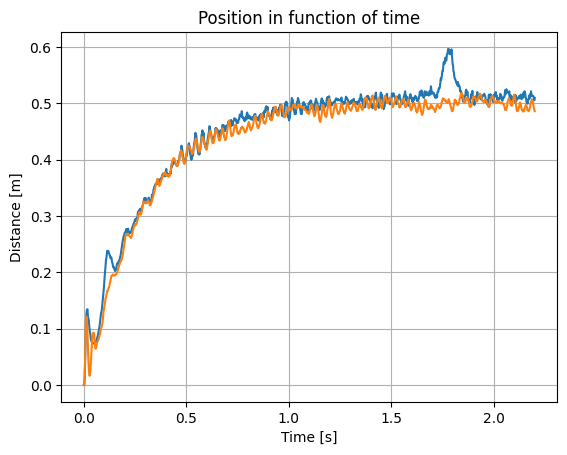

In [ ]:
plt.title("Position in function of time")
plt.plot(data["time"], data["speed_left"], label="x")
plt.plot(data["time"], data["speed_right"], label="y")
plt.xlabel("Time [s]")
plt.ylabel("Distance [m]")
# plt.xlim(-0.1,2.5)
plt.grid()
plt.show()

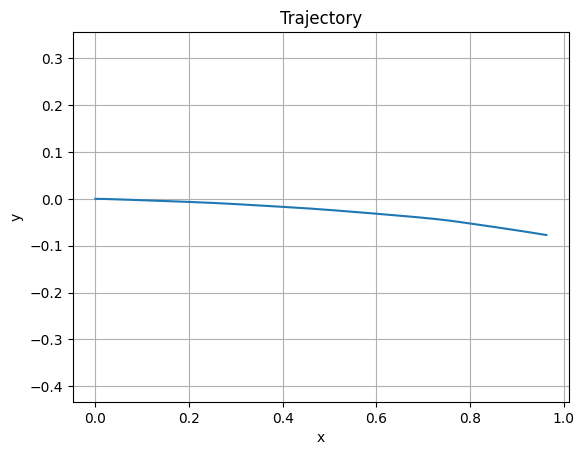

In [24]:
plt.title("Trajectory")
plt.plot(data["xpos"], data["ypos"])
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid()
plt.show()

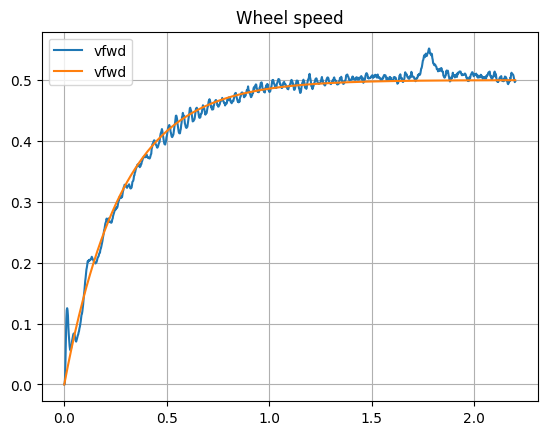

0.75


In [27]:
u = 160/240
A = 0.5/u
tau = 0.28
step_response_estimation = u*A*(1-np.exp(-data["time"]/tau)) 
plt.figure()
plt.title("Wheel speed")
mask = data["time"] <= 2.5
plt.plot(data["time"][mask], data["vfwd"][mask], label="vfwd")
plt.plot(data["time"][mask], step_response_estimation[mask], label="vfwd")
# plt.plot(data)
plt.legend()
plt.grid()
plt.show()
print(A)

In [28]:
print(A)
print(tau)
# Voir fichier matlab

0.75
0.28


In [29]:
A = 0.7575000000000001;
tau = 0.3;

# Pole placement
tau1 = tau
tau2 = tau/10
Ki1 = tau/(tau1*tau2*A)
Kp1 = (1/A)*(A*Ki1*(tau1+tau2)-1)


# 1 pole placement + PZ cancellation
tau2 = tau2
Ki2 = 1/(A*tau2)
Kp2 = tau/(A*tau2)

print("Pole placement\n-------------------")
print(f"Ki = {Ki1:.4f}\nKp = {Kp1:.4f}\n")
print("PZ cancellation\n-------------------")
print(f"Ki = {Ki2:.4f}\nKp = {Kp2:.4f}\n")


Pole placement
-------------------
Ki = 44.0044
Kp = 13.2013

PZ cancellation
-------------------
Ki = 44.0044
Kp = 13.2013

